# 3. Image Registration Metrics and Optimization

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import skimage.io as io
import numpy as np
import skimage.transform as tf
from skimage import img_as_ubyte
from scipy.ndimage.filters import maximum_filter, minimum_filter
from scipy.optimize import fmin_powell

In [2]:
def mutual_information(img_mov,img_ref):
    hgram, x_edges, y_edges = np.histogram2d(img_mov.ravel(), img_ref.ravel(), bins=20)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

#sum of squared errors
def sse(img_mov, img_ref):
    img1 = img_mov.astype('float64')
    img2 = img_ref.astype('float64')
    r = (img1 - img2)**2
    sse = np.sum(r.ravel())
    return sse

#sum of absolute value
def sav(img_mov, img_ref):
    img1 = img_mov.astype('float64')
    img2 = img_ref.astype('float64')
    ab = np.abs(img1 - img2)
    sav = np.sum(ab.ravel())
    return sav

def xcorr(img_mov,img_ref):
    # Vectorized versions of c,d,e
    a = img_mov.astype('float64')
    b = img_ref.astype('float64')

    # Calculating mean values
    AM = np.mean(a)
    BM = np.mean(b)

    c_vect = (a - AM) * (b - BM)
    d_vect = (a - AM) ** 2
    e_vect = (b - BM) ** 2

    # Finally get r using those vectorized versions
    r_out = np.sum(c_vect) / float(np.sqrt(np.sum(d_vect) * np.sum(e_vect)))
    return r_out

# 3.1 Phantom to Phantom registration

In [26]:
img_ref = io.imread('phantom2.tif')
tform = tf.AffineTransform(translation=(2,2))
img_mov = tf.warp(img_ref,tform)
img_mov = img_as_ubyte(img_mov)
#img_mov = img_ref.copy()
img_disp = np.zeros((img_ref.shape[0],img_mov.shape[1],3),dtype='uint8')
img_disp[:,:,0] = img_ref
img_disp[:,:,1] = img_mov

plt.imshow(img_disp)

In [27]:
nMetrics = 4
dx = np.arange(-10,10,2)
dy = np.arange(-10,10,2)
X, Y = np.meshgrid(dx, dy)
#metrics = np.zeros((dx.shape[0],dy.shape[0],4))

In [28]:
%matplotlib notebook

In [29]:
def do_registration(img_mv, img_rf, dx, dy, vis, pobjs):
    fig = pobjs[0]
    ax2 = pobjs[1]
    ax3 = pobjs[2]
    ax4 = pobjs[3]
    plt = pobjs[4]
    mpts = pobjs[5]

    metrics = np.zeros((dx.shape[0], dy.shape[0], 4))

    len_Dx = len(dx)
    len_Dy = len(dy)
    for i in range(len_Dy):
        for j in range(len_Dx):

            tx = dx[i]
            ty = dy[j]

            tform = tf.AffineTransform(translation=(tx, ty))
            img_reg = tf.warp(img_mv, tform)
            img_reg = img_as_ubyte(img_reg)
            img_disp = np.zeros((img_mv.shape[0], img_mv.shape[1], 3), dtype='uint8')
            img_disp[:, :, 0] = img_rf
            img_disp[:, :, 1] = img_reg

            mi = mutual_information(img_reg, img_rf)
            se = sse(img_reg, img_rf)
            sa = sav(img_reg, img_rf)
            xc = xcorr(img_reg, img_rf)

            metrics[i, j, 0] = mi
            metrics[i, j, 1] = se
            metrics[i, j, 2] = sa
            metrics[i, j, 3] = xc


            if vis:
                mpts.append(metrics[i, j, 0])  # change the index to visualize different metrics
                ax2.imshow(img_reg, cmap='gray')  # moving image
                ax3.imshow(img_disp)  # overlap
                ax4.plot(mpts, 'b-')  # metric live graph
                fig.canvas.draw()
                plt.pause(0.1)

    return metrics

<IPython.core.display.Javascript object>


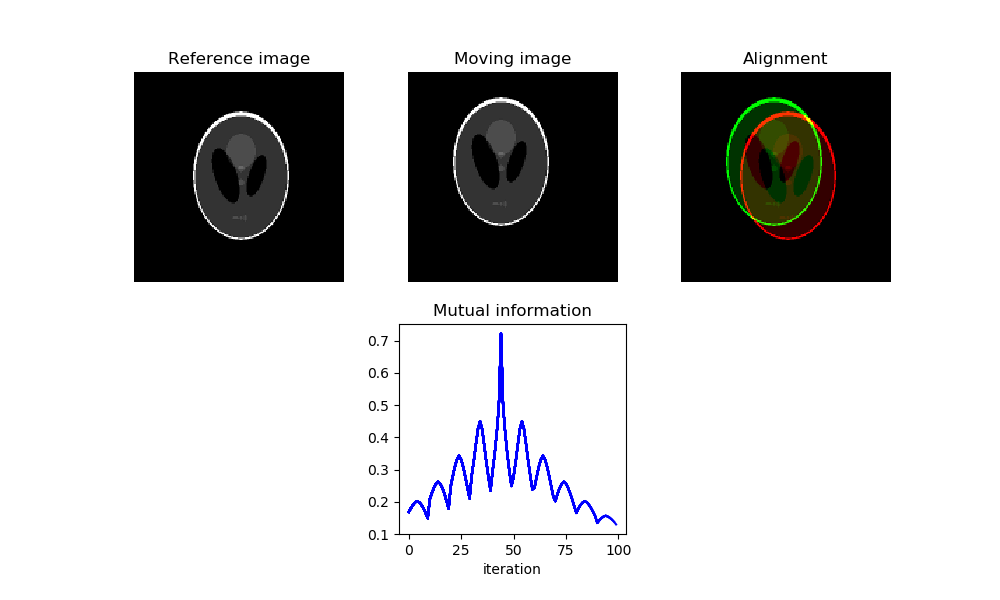

In [30]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(231)
ax1.axis('off')
ax1.title.set_text('Reference image')
ax2 = fig.add_subplot(232)
ax2.axis('off')
ax2.title.set_text('Moving image')
ax3 = fig.add_subplot(233)
ax3.axis('off')
ax3.title.set_text('Alignment')
ax4 = fig.add_subplot(235)
ax4.title.set_text('Mutual information')
ax4.set_xlabel('iteration')

ax1.imshow(img_ref, cmap='gray')
mpts = []
plt_objs = (fig, ax2, ax3, ax4, plt, mpts)


metrics = do_registration(img_mov, img_ref, dx, dy, True, plt_objs)

In [8]:
def find_global_max(mat,X,Y):
    #find global maxima
    rmx, cmx = np.unravel_index(mat.argmax(), mat.shape)
    xmax = X[rmx,cmx]
    ymax = Y[rmx,cmx]

    return xmax,ymax

def find_global_min(mat,X,Y):
    #find global minima
    rmi, cmi = np.unravel_index(mat.argmin(), mat.shape)
    xmin = X[rmi,cmi]
    ymin = Y[rmi,cmi]

    return xmin,ymin

def find_local_maxs(mat,X,Y):
    #find local maximums
    local_max = maximum_filter(mat,size=(3,3), mode='constant', cval=0)
    lmx_rows,lmx_cols = np.nonzero(local_max == mat)
    maxs = [(X[rc],Y[rc]) for rc in zip(lmx_rows,lmx_cols)]
    maxs = np.array(maxs)

    return maxs

def find_local_min(mat,X,Y):
    #find local minimums
    local_min = minimum_filter(mat,size=(3,3), mode='constant', cval=mat.max())
    lmi_rows,lmi_cols = np.nonzero(local_min == mat)
    mins = [(X[rc],Y[rc]) for rc in zip(lmi_rows,lmi_cols)]
    mins = np.array(mins)

    return mins

In [9]:
def display_metric(metric,X,Y, title):
    xmax,ymax = find_global_max(metric,X,Y)
    xmin,ymin = find_global_min(metric,X,Y)
    maxs = find_local_maxs(metric,X,Y)
    mins = find_local_min(metric,X,Y)

    fig = plt.figure(figsize=(9,4))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    ax1.plot_surface(X, Y, metric, linewidth=0, cmap='viridis', antialiased=False)
    ax1.title.set_text(title)
    ax1.set_xlabel('Dx')
    ax1.set_ylabel('Dy')

    cset = ax2.contour(X,Y,metric, colors='black')
    ax2.clabel(cset, inline=1, fontsize=5)
    ax2.contourf(X, Y, metric, cmap='viridis')

    ax2.plot(maxs[:,0],maxs[:,1],'r+', label='local max')
    ax2.plot(mins[:,0],mins[:,1],'bo', label='local min')
    ax2.plot(xmax,ymax,marker='*', markersize=8, markerfacecolor='red', label='global max')
    ax2.plot(xmin,ymin,marker='o', markersize=8, markerfacecolor='red', label='global min')

    ax2.title.set_text(title)
    ax2.set_xlabel('Dx')
    ax2.set_ylabel('Dy')
    ax2.set_xlim([dx.min()-1, dx.max()+1])
    ax2.set_ylim([dy.min()-1, dy.max()+1])
    ax2.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


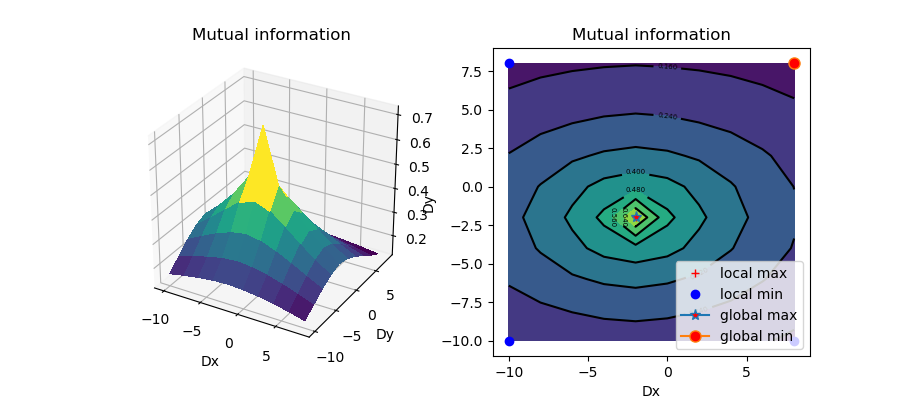

In [31]:
%matplotlib notebook
display_metric(metrics[:,:,0],X,Y,'Mutual information')

<IPython.core.display.Javascript object>


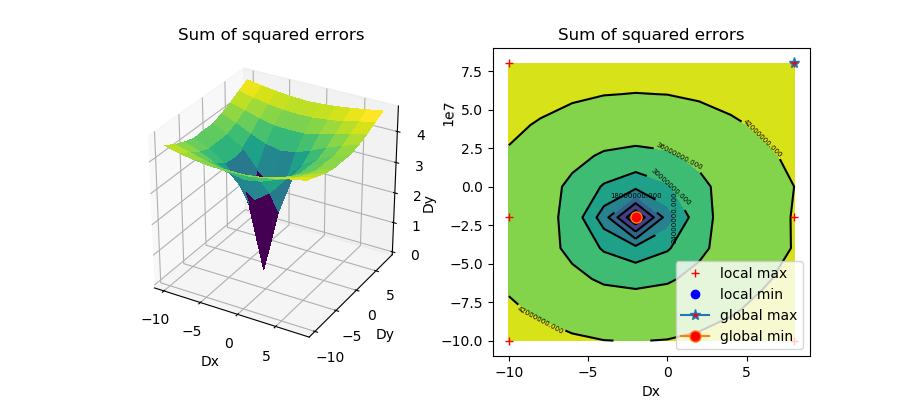

In [32]:
display_metric(metrics[:,:,1],X,Y,'Sum of squared errors')

<IPython.core.display.Javascript object>


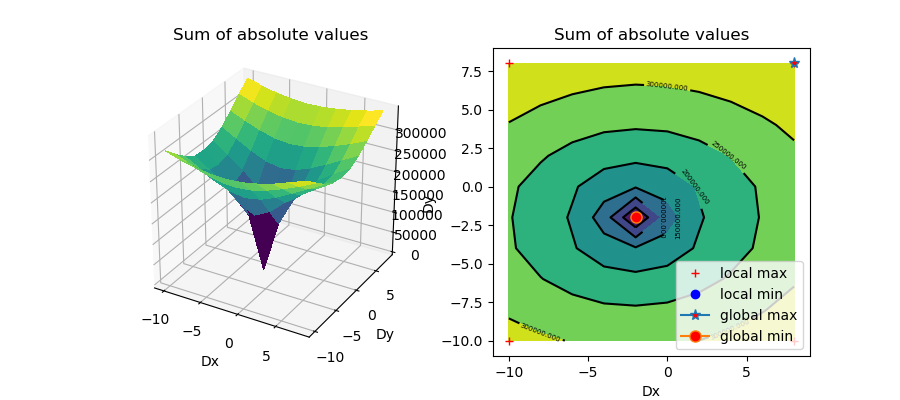

In [33]:
display_metric(metrics[:,:,2],X,Y,'Sum of absolute values')

<IPython.core.display.Javascript object>


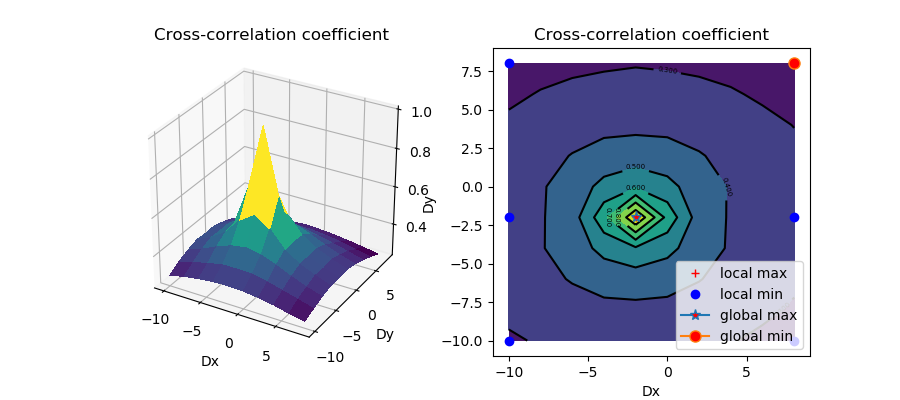

In [34]:
display_metric(metrics[:,:,3],X,Y,'Cross-correlation coefficient')

## Automatic Parameter Search

In [16]:
def opt_registration(p, img_mov,img_ref, metric_func, ismin, vis, pobjs):

    fig = pobjs[0] #fig,ax1,ax2,plt,ms
    ax1 = pobjs[1]
    ax2 = pobjs[2]
    plt = pobjs[3]
    ms = pobjs[4]

    tx,ty = p
    tform = tf.AffineTransform(translation=(tx, ty))
    img_reg = tf.warp(img_mov, tform)
    img_reg = img_as_ubyte(img_reg)
    m = metric_func(img_reg,img_ref)

    img_disp = np.zeros((img_ref.shape[0], img_mov.shape[1], 3), dtype='uint8')
    img_disp[:, :, 0] = img_ref
    img_disp[:, :, 1] = img_reg
    #print(m)

    if vis:
        ms.append(m)
        ax1.imshow(img_disp)
        ax2.plot(ms,'b-')
        fig.canvas.draw()
        plt.pause(0.1)

    if not ismin: #in not a minimizaqtion problem, used for mutual information
        m *= -1

    return m

In [17]:
img_ref = io.imread('phantom.tif')
tform = tf.AffineTransform(translation=(-10,-10))
img_mov = tf.warp(img_ref,tform)
img_mov = img_as_ubyte(img_mov)
img_disp = np.zeros((img_ref.shape[0],img_mov.shape[1],3),dtype='uint8')
img_disp[:,:,0] = img_ref
img_disp[:,:,1] = img_mov

plt.imshow(img_disp)
plt.show()

<IPython.core.display.Javascript object>


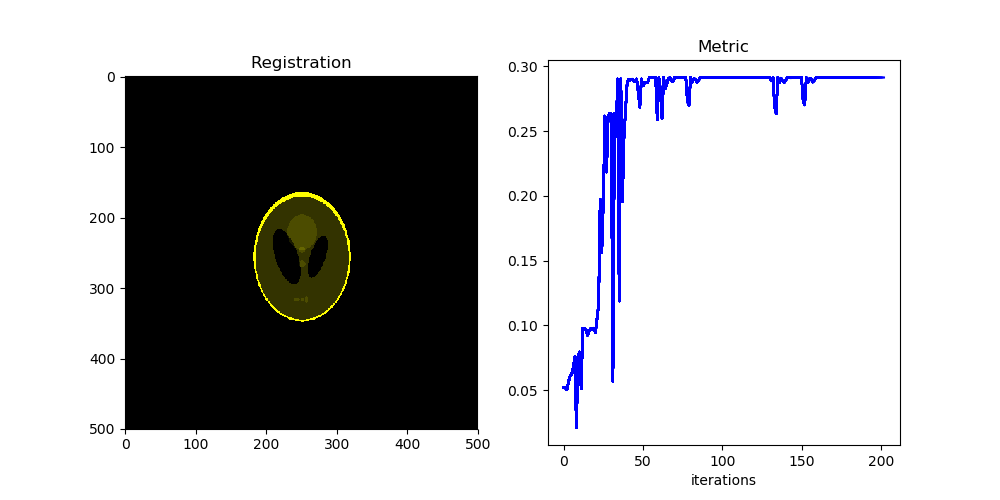

Optimization terminated successfully.
         Current function value: -0.291468
         Iterations: 4
         Function evaluations: 203
[10.02280104 10.00190799]


In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.title.set_text('Registration')
ax2.title.set_text('Metric')
ax2.set_xlabel('iterations')
ms = []
plot_objs = (fig,ax1,ax2,plt,ms)


t = [40,40]
opt = fmin_powell(opt_registration,t,args=(img_mov,img_ref, mutual_information, False, True, plot_objs),maxiter=90)
plt.close('all')
print(opt)

<IPython.core.display.Javascript object>


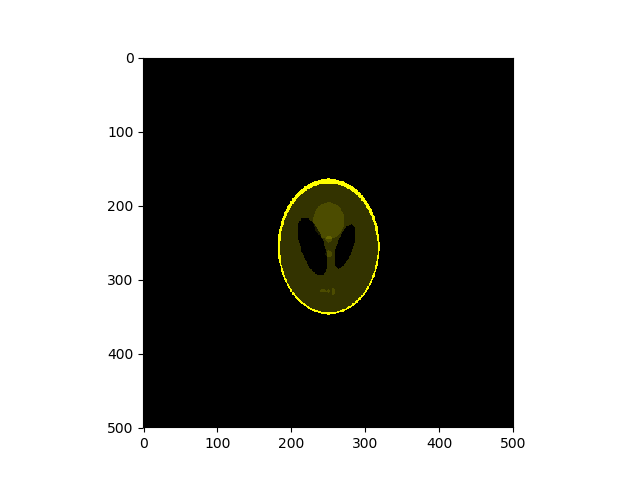

In [19]:
tform = tf.AffineTransform(translation=(opt[0],opt[1]))
img_reg = tf.warp(img_mov,tform)
img_reg = img_as_ubyte(img_reg)
img_disp = np.zeros((img_ref.shape[0],img_mov.shape[1],3),dtype='uint8')
img_disp[:,:,0] = img_ref
img_disp[:,:,1] = img_reg

plt.imshow(img_disp)
plt.show()